In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import *
from Triangle.Data import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import FDTDIResponseGenerator
from Triangle_BBH.Utils import Likelihood, Fstatistics
from Triangle_BBH.Fisher import *

import multiprocessing
if __name__=='__main__':
    multiprocessing.set_start_method("fork")

# np.random.seed(114514)
# xp.random.seed(114514)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


no cupy 
no cupy
No CuPy or GPU PhenomHM module.
has BBHx waveform


In [ ]:
import copy 

class Fstatistics(Likelihood):
    extrinsic_parameter_names = [
        "luminosity_distance", 
        "inclination", 
        "coalescence_phase", 
        "psi"
        ]
    intrinsic_parameter_names = [
        'chirp_mass',
        'mass_ratio',
        'spin_1z',
        'spin_2z',
        'coalescence_time',
        'longitude',
        'latitude'
        ]
    def __init__(self, response_generator, frequency, data, invserse_covariance_matrix, response_parameters, use_gpu=False):
        super().__init__(response_generator, frequency, data, invserse_covariance_matrix, response_parameters, use_gpu)
        self.SUM = self.xp.sum 
        self.CONJ = self.xp.conjugate
        self.RE = self.xp.real
        self.NX = self.xp.newaxis 
        self.MATMUL = self.xp.matmul
        self.TRANS = self.xp.transpose

    def self_inner_product_vectorized(self, template_channels):
        """ 
            template_channels: shape (Nevent, Nchannel, Nfreq)
        """
        residual = self.TRANS(template_channels, (0, 2, 1)) # (Nevent, 3, Nf) -> (Nevent, Nf, 3)
        residual_dagger = self.CONJ(residual[:, :, self.NX, :]) # (Nevent, Nf, 1, 3)
        residual = residual[:, :, :, self.NX] # (Nevent, Nf, 3, 1)
        inners = self.SUM(self.MATMUL(self.MATMUL(residual_dagger, self.invserse_covariance_matrix), residual), axis=(1,2,3)) # (Nevent)
        return self.RE(inners) # (Nevent)
    
    def inner_product_vectorized(self, template_channels1, template_channels2):
        """ 
            template_channels1: shape (Nevent, Nchannel, Nfreq)
            template_channels2: shape (Nevent, Nchannel, Nfreq)
        """
        residual1 = self.TRANS(template_channels1, (0, 2, 1)) # (Nevent, 3, Nf) -> (Nevent, Nf, 3)
        residual_dagger1 = self.CONJ(residual1[:, :, self.NX, :]) # (Nevent, Nf, 1, 3)

        residual2 = self.TRANS(template_channels2, (0, 2, 1)) # (Nevent, 3, Nf) -> (Nevent, Nf, 3)
        residual2 = residual2[:, :, :, self.NX] # (Nevent, Nf, 3, 1)

        inners = self.SUM(self.MATMUL(self.MATMUL(residual_dagger1, self.invserse_covariance_matrix), residual2), axis=(1,2,3)) # (Nevent)
        return self.RE(inners) # (Nevent)
    
    def calculate_Fstat(self, intrinsic_parameters, return_a=False, return_recovered_wave=False):
        """  
        calculate F-statistics for a batch of events TODO: expand to HM waveform 
        Args: 
            intrinsic_parameters: dictionary of intrinsic parameters (except for D, iota, phic, psi), each parameter is a float number. 
        Returns: 
            F-statistics
        """        
        full_parameters1 = intrinsic_parameters.copy() 
        full_parameters1["luminosity_distance"] = 0.25 
        full_parameters1["coalescence_phase"] = 0.
        full_parameters1["inclination"] = PI / 2. 
        full_parameters1["psi"] = 0.

        temp1 = self.response_generator.Response(
            parameters=full_parameters1,
            freqs=self.frequency,
            **self.response_kwargs,
        ) # (Nchannel=3, Nfreq)
        
        full_parameters2 = full_parameters1.copy() 
        full_parameters2["psi"] = PI / 4. 

        temp2 = self.response_generator.Response(
            parameters=full_parameters2,
            freqs=self.frequency,
            **self.response_kwargs,
        ) # (Nchannel=3, Nfreq)

        X1 = temp1 # (Nchannel, Nfreq)
        X2 = 1.j * X1 # (Nchannel, Nfreq)
        X3 = temp2 # (Nchannel, Nfreq)
        X4 = 1.j * X3 # (Nchannel, Nfreq) 
        # print("shape of X1:", X1.shape) # TEST 
        
        Nvector = self.RE(self.xp.array([
            FrequencyDomainCovarianceInnerProduct(self.data, X1, self.invserse_covariance_matrix), 
            FrequencyDomainCovarianceInnerProduct(self.data, X2, self.invserse_covariance_matrix),
            FrequencyDomainCovarianceInnerProduct(self.data, X3, self.invserse_covariance_matrix),
            FrequencyDomainCovarianceInnerProduct(self.data, X4, self.invserse_covariance_matrix),
        ])) # (4,) all real numbers 
        # print("shape of N vector:", Nvector.shape) # TEST 
        
        M12 = FrequencyDomainCovarianceInnerProduct(X1, X2, self.invserse_covariance_matrix)
        M13 = FrequencyDomainCovarianceInnerProduct(X1, X3, self.invserse_covariance_matrix)
        M14 = FrequencyDomainCovarianceInnerProduct(X1, X4, self.invserse_covariance_matrix)
        M23 = FrequencyDomainCovarianceInnerProduct(X2, X3, self.invserse_covariance_matrix)
        M24 = FrequencyDomainCovarianceInnerProduct(X2, X4, self.invserse_covariance_matrix)
        M34 = FrequencyDomainCovarianceInnerProduct(X3, X4, self.invserse_covariance_matrix)
        Mmatrix = self.RE(self.xp.array([
            [FrequencyDomainCovarianceInnerProduct(X1, X1, self.invserse_covariance_matrix), M12, M13, M14], 
            [M12, FrequencyDomainCovarianceInnerProduct(X2, X2, self.invserse_covariance_matrix), M23, M24], 
            [M13, M23, FrequencyDomainCovarianceInnerProduct(X3, X3, self.invserse_covariance_matrix), M34], 
            [M14, M24, M34, FrequencyDomainCovarianceInnerProduct(X4, X4, self.invserse_covariance_matrix)]
        ])) # (4, 4) all real numbers 
        # print("shape of M matrix:", Mmatrix.shape) # TEST 
        
        # invMmatrix = self.xp.linalg.inv(Mmatrix) # (4, 4)
        # NM = self.MATMUL(invMmatrix, Nvector) # (4,)
        # NMN = self.MATMUL(Nvector, NM) # float 
        NM = np.linalg.solve(Mmatrix, Nvector) # (4,)
        res = 0.5 * Nvector @ NM # float, Fstat 0.5 * N^T M^{-1} N
        
        if return_a:
            res_a = NM
            return res_a # (4,)
            
        if return_recovered_wave: 
            res_a = NM # (4,)
            res_wf = res_a[0] * X1 + res_a[1] * X2 + res_a[2] * X3 + res_a[3] * X4 # (Nchannel, Nfreq)
            return res_wf # (Nchannel, Nfreq)

        return float(res) # float 

    def calculate_Fstat_vectorized(self, intrinsic_parameters, return_a=False, return_recovered_wave=False):
        """  
        calculate F-statistics for a batch of events TODO: expand to HM waveform 
        Args: 
            intrinsic_parameters: dictionary of intrinsic parameters (except for D, iota, phic, psi), each item is a numpy array of shape (Nevent). 
        Returns: 
            F-statistics of events 
        """
        Nevent = len(np.atleast_1d(intrinsic_parameters["chirp_mass"]))
        
        full_parameters1 = copy.deepcopy(intrinsic_parameters)
        full_parameters1["luminosity_distance"] = np.ones(Nevent) * 0.25 
        full_parameters1["coalescence_phase"] = np.zeros(Nevent)
        full_parameters1["inclination"] = np.ones(Nevent) * PI / 2. 
        full_parameters1["psi"] = np.zeros(Nevent)
        # print("1st parameter set:") # TEST 
        # print(full_parameters1) # TEST 

        temp1 = self.response_generator.Response(
            parameters=full_parameters1,
            freqs=self.frequency,
            **self.response_kwargs,
        ) # (Nchannel=3, Nevent, Nfreq)
        
        full_parameters2 = copy.deepcopy(full_parameters1)
        full_parameters2["psi"] = np.ones(Nevent) * PI / 4. 
        # print("2nd parameter set:") # TEST 
        # print(full_parameters2) # TEST 

        temp2 = self.response_generator.Response(
            parameters=full_parameters2,
            freqs=self.frequency,
            **self.response_kwargs,
        ) # (Nchannel=3, Nevent, Nfreq)

        if Nevent == 1:
            temp1 = temp1[:, self.NX, :]
            temp2 = temp2[:, self.NX, :]

        X1 = self.TRANS(temp1, axes=(1, 0, 2)) # (Nevent, Nchannel, Nfreq)
        X2 = 1.j * X1 # (Nevent, Nchannel, Nfreq)
        X3 = self.TRANS(temp2, axes=(1, 0, 2)) # (Nevent, Nchannel, Nfreq)
        X4 = 1.j * X3 # (Nevent, Nchannel, Nfreq) 
        # print("shape of X1:", X1.shape) # TEST 
        
        data_expand = self.data[self.NX, :, :] # (1, Nchannel, Nfreq)
        Nvector = self.TRANS(self.xp.array([
            self.inner_product_vectorized(data_expand, X1), 
            self.inner_product_vectorized(data_expand, X2), 
            self.inner_product_vectorized(data_expand, X3), 
            self.inner_product_vectorized(data_expand, X4), 
        ])) # (4, Nevent) -> (Nevent, 4) inner products, all real numbers 
        # print("shape of N vector:", Nvector.shape) # TEST 
        
        M12 = self.inner_product_vectorized(X1, X2) # (Nevent), real numbers 
        M13 = self.inner_product_vectorized(X1, X3)
        M14 = self.inner_product_vectorized(X1, X4)
        M23 = self.inner_product_vectorized(X2, X3)
        M24 = self.inner_product_vectorized(X2, X4)
        M34 = self.inner_product_vectorized(X3, X4)
        Mmatrix = self.TRANS(self.xp.array([
            [self.self_inner_product_vectorized(X1), M12, M13, M14], 
            [M12, self.self_inner_product_vectorized(X2), M23, M24], 
            [M13, M23, self.self_inner_product_vectorized(X3), M34], 
            [M14, M24, M34, self.self_inner_product_vectorized(X4)]
        ]), axes=(2, 0, 1)) # (4, 4, Nevent) -> (Nevent, 4, 4) inner products, all real numbers 
        # print("shape of M matrix:", Mmatrix.shape) # TEST 
        
        invMmatrix = self.xp.linalg.inv(Mmatrix) # (Nevent, 4, 4)
        Nvector_col = Nvector[..., self.NX] # (Nevent, 4, 1)
        NM = self.MATMUL(invMmatrix, Nvector_col) # (Nevent, 4, 1)
        Nvector_row = Nvector[:, self.NX, :] # (Nevent, 1, 4)
        NMN = self.MATMUL(Nvector_row, NM) # (Nevent, 1, 1)
        
        res = 0.5 * NMN[:, 0, 0] # (Nevent) Fstat 0.5 * N^T M^{-1} N
        
        if return_a:
            res_a = NM.squeeze(axis=-1) # (Nevent, 4)
            if self.use_gpu:
                return res_a.get() # (Nevent, 4)
            else: 
                return res_a # (Nevent, 4)
            
        if return_recovered_wave: 
            res_a = NM.squeeze(axis=-1) # (Nevent, 4)
            res_wf = res_a[:, 0] * self.TRANS(X1, axes=(1, 2, 0)) # (Nchannel, Nfreq, Nevent)
            res_wf += res_a[:, 1] * self.TRANS(X2, axes=(1, 2, 0))
            res_wf += res_a[:, 2] * self.TRANS(X3, axes=(1, 2, 0))
            res_wf += res_a[:, 3] * self.TRANS(X4, axes=(1, 2, 0)) 
            if Nevent == 1: 
                return res_wf[:, :, 0] # (Nchannel, Nfreq)
            else:
                return self.TRANS(res_wf, (0, 2, 1)) # (Nchannel, Nevent, Nfreq)

        # else:
        if self.use_gpu:
            if Nevent == 1:
                return res.get()[0]
            else:
                return res.get() # (Nevent)
        else: 
            if Nevent == 1: 
                return res[0]
            else: 
                return res 

    @staticmethod
    def a_to_extrinsic(a):
        """ 
        TODO: expand to HM waveform 
        Args: 
            a: (4), numpy array of the a coefficients 
        Returns: 
            dictionary of extrinsic parameters 
        """
        extrinsic_parameters = dict()
        
        P = np.linalg.norm(a) ** 2 # float 
        Q = a[1] * a[2] - a[0] * a[3] # float 
        Delta = np.sqrt(P ** 2 - 4. * Q ** 2) # float 
        Aplus = np.sqrt((P + Delta) / 2.) # float
        Across = np.sign(Q) * np.sqrt((P - Delta) / 2.) # float
        
        tmp = Aplus + np.sqrt(Aplus ** 2 - Across ** 2) # float 
        extrinsic_parameters["luminosity_distance"] = 0.5 / tmp # float 
        extrinsic_parameters["inclination"] = np.arccos(Across / tmp) # float 
        # extrinsic_parameters["coalescence_phase"] = -np.arctan(2. * (a[:, 0] * a[:, 1] + a[:, 2] * a[:, 3]) / (a[:, 0] ** 2 + a[:, 2] ** 2 - a[:, 1] ** 2 - a[:, 3] ** 2)) / 2. # (Nevent), one possible solution 
        # extrinsic_parameters["psi"] = np.arctan(2. * (a[:, 0] * a[:, 2] + a[:, 1] * a[:, 3]) / (a[:, 0] ** 2 + a[:, 1] ** 2 - a[:, 2] ** 2 - a[:, 3] ** 2)) / 4. # (Nevent), one possible solution 

        P = np.sqrt((a[0] + a[3])**2 + (a[1] - a[2])**2) # float 
        Q = np.sqrt((a[0] - a[3])**2 + (a[1] + a[2])**2) # float 
        Aplus = P + Q # float 
        Across = P - Q # float 
        extrinsic_parameters["psi"] = 0.5 * np.arctan2(Aplus*a[3] - Across*a[0], Aplus*a[1] + Across*a[2]) # float (-PI/2, PI/2)
        sgns2p = np.sign(np.sin(2. * extrinsic_parameters["psi"]))
        extrinsic_parameters["coalescence_phase"] = -0.5*np.arctan2((Aplus*a[3] - Across*a[0])*sgns2p, (Aplus*a[2] + Across*a[1])*sgns2p) # float (-PI/2, PI/2)
        if extrinsic_parameters["psi"] < 0: 
            extrinsic_parameters["psi"] += PI # (0, PI)
        if extrinsic_parameters["coalescence_phase"] < 0.: 
            extrinsic_parameters["coalescence_phase"] += PI # (0, PI)
           
        return extrinsic_parameters
        
    @staticmethod
    def a_to_extrinsic_vectorized(a):
        """ 
        TODO: expand to HM waveform 
        Args: 
            a: (Nevent, 4), numpy array of the a coefficients 
        Returns: 
            dictionary of extrinsic parameters 
        """
        extrinsic_parameters = dict()
        
        P = np.linalg.norm(a, axis=1) ** 2 # (Nevent)
        Q = a[:, 1] * a[:, 2] - a[:, 0] * a[:, 3] # (Nevent)
        Delta = np.sqrt(P ** 2 - 4. * Q ** 2) # (Nevent)
        Aplus = np.sqrt((P + Delta) / 2.) # (Nevent)
        Across = np.sign(Q) * np.sqrt((P - Delta) / 2.) # (Nevent)
        
        tmp = Aplus + np.sqrt(Aplus ** 2 - Across ** 2) # (Nevent)
        extrinsic_parameters["luminosity_distance"] = 0.5 / tmp # (Nevent)
        extrinsic_parameters["inclination"] = np.arccos(Across / tmp) # (Nevent)
        # extrinsic_parameters["coalescence_phase"] = -np.arctan(2. * (a[:, 0] * a[:, 1] + a[:, 2] * a[:, 3]) / (a[:, 0] ** 2 + a[:, 2] ** 2 - a[:, 1] ** 2 - a[:, 3] ** 2)) / 2. # (Nevent), one possible solution 
        # extrinsic_parameters["psi"] = np.arctan(2. * (a[:, 0] * a[:, 2] + a[:, 1] * a[:, 3]) / (a[:, 0] ** 2 + a[:, 1] ** 2 - a[:, 2] ** 2 - a[:, 3] ** 2)) / 4. # (Nevent), one possible solution 

        P = np.sqrt((a[:, 0] + a[:, 3])**2 + (a[:, 1] - a[:, 2])**2)
        Q = np.sqrt((a[:, 0] - a[:, 3])**2 + (a[:, 1] + a[:, 2])**2)
        Aplus = P + Q 
        Across = P - Q 
        extrinsic_parameters["psi"] = 0.5 * np.arctan2(Aplus*a[:, 3] - Across*a[:, 0], Aplus*a[:, 1] + Across*a[:, 2]) # (Nevent)
        sgns2p = np.sign(np.sin(2. * extrinsic_parameters["psi"])) # (Nevent)
        extrinsic_parameters["coalescence_phase"] = -0.5*np.arctan2((Aplus*a[:, 3] - Across*a[:, 0]) * sgns2p / (Aplus*a[:, 2] + Across*a[:, 1]) * sgns2p) # (Nevent)
        extrinsic_parameters["psi"][extrinsic_parameters["psi"]<0.] += PI 
        extrinsic_parameters["coalescence_phase"][extrinsic_parameters["coalescence_phase"]<0.] += PI 
        
        if a.shape[0] == 1:
            extrinsic_parameters_out = dict() 
            for k, v in extrinsic_parameters.items():
                extrinsic_parameters_out[k] = float(v[0])
            return extrinsic_parameters_out
        else:              
            return extrinsic_parameters
    
    @staticmethod
    def IntParamDict2ParamArr(param_dict):
        return np.array([
            np.log10(param_dict['chirp_mass']),
            param_dict['mass_ratio'],
            param_dict['spin_1z'],
            param_dict['spin_2z'],
            param_dict['coalescence_time'],
            param_dict['longitude'],
            np.sin(param_dict['latitude']),
        ]) # (Nparams, Nevent)

    @staticmethod
    def IntParamArr2ParamDict(params):
        p = dict()
        p['chirp_mass'] = np.power(10., params[0])
        p['mass_ratio'] = params[1]
        p['spin_1z'] = params[2]
        p['spin_2z'] = params[3]
        p['coalescence_time'] = params[4]
        p['longitude'] = params[5]
        p['latitude'] = np.arcsin(params[6])
        return p 

## Data settings 

In [3]:
t_start = 200. * DAY # start time in s
Tobs = 5. * DAY # data length in s 
t_end = t_start + Tobs # end time in s 
dt = 10. # time cadance in s 
fsample = 1. / dt # sampling rate in Hz 
data_frequencies_full = np.fft.rfftfreq(n=int(Tobs/dt), d=dt) # frequecies where waveform will be calculated 
delta_f = 1. / Tobs

data_frequencies_full.shape 

(21601,)

In [4]:
# mask the "null" frequencies, which may cause singularity in the calculation of likelihood 
mask = np.ones_like(data_frequencies_full, dtype=bool)
for i in range(1, 50): 
    mask_idx = np.where(np.abs(data_frequencies_full - i*0.025)<i*5e-4)[0]
    mask[mask_idx] = False 

# remove the frequencies below Taiji sensitive band 
mask_idx = np.where(data_frequencies_full < 1e-5)[0]
mask[mask_idx] = False 

data_frequencies = data_frequencies_full[mask]
data_frequencies_CPU = np.array(data_frequencies)

valid_idx = np.where(mask == True)[0]

data_frequencies.shape, valid_idx.shape 

((20732,), (20732,))

## Set response model 

In [5]:
# the path of Taiji orbit 
# orbit_CPU = Orbit(OrbitDir="../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB") 
orbit_CPU = Orbit(OrbitDir="/Users/taijidatacenter/Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB")

# initialize  waveform generator 
WFG_CPU = WaveformGenerator(
    mode="primary", 
    # mode="full", 
)

# initialize response generator 
FDTDI_CPU = FDTDIResponseGenerator(
    orbit_class=orbit_CPU, 
    waveform_generator=WFG_CPU, 
)

# response settings 
response_kwargs_CPU = dict(
    modes=[(2, 2)], 
    tmin=t_start / DAY, # start time in day 
    tmax=t_end / DAY, # end time in day  
    tc_at_constellation=True, # whether tc is the coalescence time at constellation center (True) or SSB (False)
    TDIGeneration='2nd',
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
)

## Source parameter priors 

In [6]:
lgMc_prior = [5.5, 6.5]
q_prior = [0.1, 1]
s1_prior = [-0.9, 0.9]
s2_prior = [-0.9, 0.9]
tc_prior = [(t_start + 0.75 * Tobs) / DAY, (t_end - 0.1 * Tobs) / DAY] # ensure the inclusion of long enough GW waveform 
lam_prior = [0, TWOPI]
sinbeta_prior = [-1., 1.]
intrinsic_param_priors = np.array([
    lgMc_prior, 
    q_prior, 
    s1_prior, 
    s2_prior, 
    tc_prior, 
    lam_prior, 
    sinbeta_prior, 
])

lgdl_prior = [4., 5.]

intrinsic_param_priors

array([[ 5.50000000e+00,  6.50000000e+00],
       [ 1.00000000e-01,  1.00000000e+00],
       [-9.00000000e-01,  9.00000000e-01],
       [-9.00000000e-01,  9.00000000e-01],
       [ 2.03750000e+02,  2.04500000e+02],
       [ 0.00000000e+00,  6.28318531e+00],
       [-1.00000000e+00,  1.00000000e+00]])

In [7]:
intrinsic_param_priors[4]

array([203.75, 204.5 ])

## Noise model 

In [8]:
arm_time = np.mean(intrinsic_param_priors[4]) * DAY 
print(arm_time/DAY)
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit_CPU.LTTfunctions()[key](arm_time)

# theoretical PSDs at the given armlengths 
PSDfunc = TDIPSDs()
PSD_channels = np.array([
    PSDfunc.PSD_A2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_E2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_T2_unequal(data_frequencies, arms)
])

# covariance matrix 
CovMat = np.array([
    [PSD_channels[0], np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), PSD_channels[1], np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = np.linalg.inv(np.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)
InvCovMat[:, 2, 2] *= 0. # use A, E channels only in the following analysis 

PSD_channels.shape, InvCovMat.shape 

204.125


((3, 20732), (20732, 3, 3))

## Data simulation 

In [9]:
# generate source parameter and clean signal 
mbhb_parameters = {
    'chirp_mass': np.power(10., np.random.uniform(lgMc_prior[0], lgMc_prior[1])), 
    'mass_ratio': np.random.uniform(q_prior[0], q_prior[1]), 
    'spin_1z': np.random.uniform(s1_prior[0], s1_prior[1]),
    'spin_2z': np.random.uniform(s2_prior[0], s2_prior[1]),
    'coalescence_time': np.random.uniform(tc_prior[0], tc_prior[1]), 
    'coalescence_phase': np.random.uniform(0, TWOPI),
    'luminosity_distance': np.power(10., np.random.uniform(lgdl_prior[0], lgdl_prior[1])), 
    'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
    'longitude': np.random.uniform(lam_prior[0], lam_prior[1]), # [rad]
    'latitude': np.arcsin(np.random.uniform(sinbeta_prior[0], sinbeta_prior[1])), # [rad]
    'psi': np.random.uniform(0, PI) # [rad]
    }
wf_channels = FDTDI_CPU.Response(mbhb_parameters, data_frequencies_CPU, **response_kwargs_CPU)

# generate frequency-domain noises 
Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
noise_channels = np.array(Re_tmp + 1.j * Im_tmp) 

# combine signal and noise 
data_channels = wf_channels + noise_channels 

opt_SNR = FrequencyDomainCovarianceSNR(wf_channels, InvCovMat)

print("source parameters:")
for k, v in mbhb_parameters.items():
    print(k, ":", v)
print("optimal SNR:", opt_SNR)

source parameters:
chirp_mass : 418458.2418663455
mass_ratio : 0.26279350976950955
spin_1z : 0.2745797487990115
spin_2z : 0.7546886490604284
coalescence_time : 203.87126659754813
coalescence_phase : 5.146937086963764
luminosity_distance : 93014.32006046669
inclination : 0.9149325189311814
longitude : 2.005772154708913
latitude : -0.4794985771723928
psi : 1.5170774662544442
optimal SNR: 366.78811664208746


Text(0, 0.5, 'Frequency-domain data (1/Hz)')

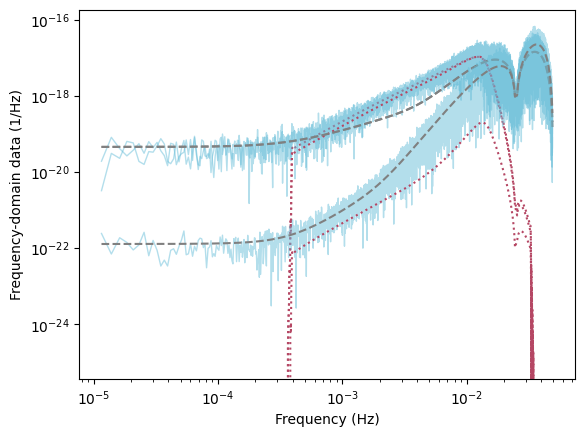

In [10]:
for ichannel, nchannel in enumerate(["A", "E", "T"]): 
    plt.loglog(data_frequencies, np.abs(data_channels[ichannel]), linewidth=1, alpha=0.5, color=BLUE)
    plt.loglog(data_frequencies, np.abs(wf_channels[ichannel]), color=RED, linestyle=":")
    plt.loglog(data_frequencies, np.sqrt(PSD_channels[ichannel] * Tobs / 2.), color="grey", linestyle="--")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency-domain data (1/Hz)")

## MLE with  $\mathcal{F}$-stat 

In [11]:
Fstat = Fstatistics(
    response_generator=FDTDI_CPU, 
    frequency=data_frequencies_CPU, 
    data=data_channels, 
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_CPU, 
    use_gpu=False
)

### test waveform and parameter recovery

In [12]:
int_params = dict()
for key in Fstatistics.intrinsic_parameter_names:
    int_params[key] = mbhb_parameters[key]
int_params

{'chirp_mass': 418458.2418663455,
 'mass_ratio': 0.26279350976950955,
 'spin_1z': 0.2745797487990115,
 'spin_2z': 0.7546886490604284,
 'coalescence_time': 203.87126659754813,
 'longitude': 2.005772154708913,
 'latitude': -0.4794985771723928}

In [13]:
rec_a = Fstat.calculate_Fstat(
    intrinsic_parameters=int_params, 
    return_a=True, 
)
# print(rec_a.shape)

rec_ext_params = Fstat.a_to_extrinsic(rec_a)

rec_params = dict(int_params, **rec_ext_params)

print("parameter name | true value | difference")
for k, v in rec_ext_params.items():
    print(k, ":", mbhb_parameters[k], v-mbhb_parameters[k])

parameter name | true value | difference
luminosity_distance : 93014.32006046669 1296.067017484209
inclination : 0.9149325189311814 -0.014639524467137233
psi : 1.5170774662544442 0.0021971502959903244
coalescence_phase : 5.146937086963764 -3.1372691597099367


In [14]:
rec_params
rec_wave1 = FDTDI_CPU.Response(
    rec_params, 
    data_frequencies_CPU, 
    **response_kwargs_CPU
)

rec_wave2 = Fstat.calculate_Fstat(
    intrinsic_parameters=int_params, 
    return_recovered_wave=True, 
)

rec_wave1.shape, rec_wave2.shape 

((3, 20732), (3, 20732))

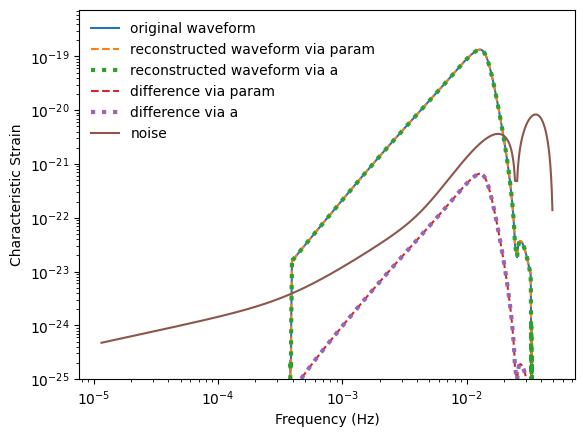

In [15]:
plt.loglog(data_frequencies, np.abs(wf_channels[0]) * data_frequencies, label="original waveform")
plt.loglog(data_frequencies, np.abs(rec_wave1[0]) * data_frequencies, linestyle="--", label="reconstructed waveform via param")
plt.loglog(data_frequencies, np.abs(rec_wave2[0]) * data_frequencies, linestyle=":", label="reconstructed waveform via a", linewidth=3)
plt.loglog(data_frequencies, np.abs(rec_wave1[0] - wf_channels[0]) * data_frequencies, label="difference via param", linestyle="--")
plt.loglog(data_frequencies, np.abs(rec_wave2[0] - wf_channels[0]) * data_frequencies, label="difference via a", linestyle=":", linewidth=3)
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies), label="noise")
plt.ylim(1e-25,)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")
plt.legend(loc="upper left", frameon=False)

### optimization from prior 

In [17]:
from scipy.optimize import differential_evolution

def cost_function(norm_int_params):
    """   
        norm_int_params: shape (Nparams), normalized to (0, 1)
    """
    int_params = norm_int_params * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0] # (Nparams)
    params_in = Fstat.IntParamArr2ParamDict(int_params) # (Nparams) -> dictionary
    return -Fstat.calculate_Fstat(intrinsic_parameters=params_in) # float

n_dim_int = 7 
lower_bounds = np.zeros(n_dim_int) 
upper_bounds = np.ones(n_dim_int) 
bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

DE_result = differential_evolution(
    func=cost_function,
    bounds=bounds,
    x0=None,
    strategy='best1exp',
    # strategy='rand1bin',
    maxiter=5000,
    popsize=10*n_dim_int,
    # popsize=6*n_dim_int, 
    tol=1e-8,
    atol=1e-10,
    # tol=1e-6,
    # atol=1e-8,
    mutation=(0.4, 0.95),
    recombination=0.7,
    disp=False,
    polish=True,
    # vectorized=True,
    workers=-1, 
)

/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:199: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), np.fabs(fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2))
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packag

In [18]:
print(DE_result)

             message: Optimization terminated successfully.
             success: True
                 fun: -5302592.79490218
                   x: [ 6.975e-01  5.655e-01  6.904e-01  7.626e-01
                        6.505e-01  4.449e-01  5.444e-01]
                 nit: 254
                nfev: 124982
          population: [[ 6.975e-01  5.655e-01 ...  4.449e-01  5.444e-01]
                       [ 6.975e-01  5.641e-01 ...  4.447e-01  5.429e-01]
                       ...
                       [ 6.975e-01  5.659e-01 ...  4.444e-01  5.453e-01]
                       [ 6.975e-01  5.654e-01 ...  4.448e-01  5.437e-01]]
 population_energies: [-5.303e+06 -5.303e+06 ... -5.303e+06 -5.303e+06]
                 jac: [-1.082e+03  5.020e+01  2.210e+02  1.190e+02
                        1.590e+03 -2.794e+00 -1.946e+01]


### reconstruct parameters and waveforms 

In [19]:
from copy import deepcopy

# get all params 
searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])
searched_a = Fstat.calculate_Fstat(
    intrinsic_parameters=searched_int_params, 
    return_a=True, 
) # (1, 4)
searched_ext_params = Fstat.a_to_extrinsic(searched_a)
searched_params = dict(searched_int_params, **searched_ext_params)
# print("init search:")
# print(searched_params)

# reconstruct waveform 
searched_wf = Fstat.calculate_Fstat(
    intrinsic_parameters=searched_int_params, 
    return_recovered_wave=True
) # (3, Nfreq)

# refine psi and phase 
matched_flag = False 
for psi_offset in [0., PI/2]:
    for phi_offset in [0., PI/2.]:
        rec_params_try = deepcopy(searched_params)
        rec_params_try["psi"] = (rec_params_try["psi"] + psi_offset)%PI
        rec_params_try["coalescence_phase"] = (rec_params_try["coalescence_phase"] + phi_offset)%TWOPI 
        rec_wf_try = FDTDI_CPU.Response(
            rec_params_try,
            data_frequencies_CPU, 
            **response_kwargs_CPU, 
        )
        res_snr_tmp = FrequencyDomainCovarianceSNR(rec_wf_try-searched_wf, InvCovMat)
        if res_snr_tmp < 1.: 
            print("best fit snr:", res_snr_tmp)
            matched_flag = True 
            searched_params = rec_params_try
            break
    if matched_flag:
        break 

# get reflected params 
lon_ssb = searched_params["longitude"]
lat_ssb = searched_params["latitude"]
psi_ssb = searched_params["psi"]
lon_det, lat_det, psi_det = SSBPosToDetectorFrame(lon_ssb, lat_ssb, psi_ssb, searched_params["coalescence_time"]*DAY, orbit_CPU)
lat_det = -lat_det # reflect latitutde 
psi_det = PI - psi_det # reflect psi 
searched_ref_params = deepcopy(searched_params)
searched_ref_params["longitude"], searched_ref_params["latitude"], searched_ref_params["psi"] = DetectorPosToSSBFrame(lon_det, lat_det, psi_det, searched_params["coalescence_time"]*DAY, orbit_CPU)
searched_ref_params["inclination"] = PI - searched_params["inclination"] # reflect inclination 

print("parameter name | true value | searched value | searched value (reflection)")
for k, v in searched_params.items():
    print(k, mbhb_parameters[k], v, searched_ref_params[k])

best fit snr: 1.287337968447421e-06
parameter name | true value | searched value | searched value (reflection)
chirp_mass 1576331.5445634555 1575804.7442541972 1575804.7442541972
mass_ratio 0.607073654937139 0.6089373942696222 0.6089373942696222
spin_1z 0.35487033487833586 0.34271618867804265 0.34271618867804265
spin_2z 0.45264651570949843 0.4725960552252949 0.4725960552252949
coalescence_time 204.23789645517817 204.23789460987538 204.23789460987538
longitude 2.7799366430752728 2.7954203670499633 3.730108851982722
latitude 0.06489970734952943 0.08887798736650283 -0.4207853393745119
luminosity_distance 15904.33324792477 15731.865441856125 15731.865441856125
inclination 1.7355374316712173 1.7332716158039014 1.4083210377858917
psi 2.7486353056467197 2.7601613223348127 1.3191178514692234
coalescence_phase 5.266798613837744 2.130281774409961 2.130281774409961


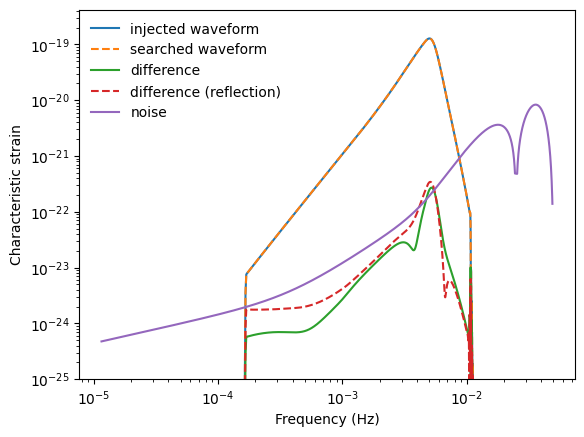

In [20]:
searched_wf1 = FDTDI_CPU.Response(
    searched_params, 
    data_frequencies_CPU, 
    **response_kwargs_CPU
)

searched_wf2 = FDTDI_CPU.Response(
    searched_ref_params, 
    data_frequencies_CPU, 
    **response_kwargs_CPU
)

plt.loglog(data_frequencies, np.abs(wf_channels[0]) * data_frequencies, label="injected waveform")
plt.loglog(data_frequencies, np.abs(searched_wf1[0]) * data_frequencies, linestyle="--", label="searched waveform")
plt.loglog(data_frequencies, np.abs(searched_wf1[0] - wf_channels[0]) * data_frequencies, linestyle="-", label="difference")
plt.loglog(data_frequencies, np.abs(searched_wf2[0] - wf_channels[0]) * data_frequencies, linestyle="--", label="difference (reflection)")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies), label="noise")
plt.ylim(1e-25, )
plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic strain")
plt.legend(loc="upper left", frameon=False)

## Fisher analysis 

In [21]:
def fisher_waveform_wrapper(param_dict, frequencies):
    res = FDTDI_CPU.Response(
        parameters=param_dict, 
        freqs=np.array(frequencies),  
        **response_kwargs_CPU, 
    )
    return res

# set initial steps 
analyze_param_step_dict = {
    'chirp_mass': 10.,
    'mass_ratio': 0.01,
    'spin_1z': 0.01,
    'spin_2z': 0.01,
    'coalescence_time': 0.001,
    'coalescence_phase': 0.01,
    'luminosity_distance': 10.,
    'inclination': 0.01,
    'longitude': 0.01,
    'latitude': 0.01,
    'psi': 0.01
    }
for k, v in analyze_param_step_dict.items():
    analyze_param_step_dict[k] = -v 

FIM = MultiChannelFisher(
    waveform_generator=fisher_waveform_wrapper, 
    param_dict=mbhb_parameters, 
    # param_dict=searched_params, 
    analyze_param_step_dict=analyze_param_step_dict, 
    frequency=data_frequencies, 
    inverse_covariance=InvCovMat, 
    verbose=0,
)

FIM.auto_test_step()
FIM.calculate_Fisher()
FIM.calculate_errors() 

FIM.param_errors

{'chirp_mass': 285.8773633008972,
 'mass_ratio': 0.002720667095288977,
 'spin_1z': 0.01189854008954207,
 'spin_2z': 0.020584147004977956,
 'coalescence_time': 1.7319087087361599e-06,
 'coalescence_phase': 0.0036081306649408053,
 'luminosity_distance': 759.9817237657154,
 'inclination': 0.004823897450613027,
 'longitude': 0.028661524395031945,
 'latitude': 0.015320661084527277,
 'psi': 0.011816835263590869}

In [22]:
print("parameter name | difference | difference (ref) | FIM bound")
for k, v in searched_params.items():
    print(k, np.abs(v-mbhb_parameters[k]), np.abs(searched_ref_params[k] - mbhb_parameters[k]), FIM.param_errors[k])

parameter name | difference | difference (ref) | FIM bound
chirp_mass 526.8003092582803 526.8003092582803 285.8773633008972
mass_ratio 0.001863739332483183 0.001863739332483183 0.002720667095288977
spin_1z 0.012154146200293203 0.012154146200293203 0.01189854008954207
spin_2z 0.019949539515796477 0.019949539515796477 0.020584147004977956
coalescence_time 1.8453027905707131e-06 1.8453027905707131e-06 1.7319087087361599e-06
longitude 0.015483723974690555 0.9501722089074494 0.028661524395031945
latitude 0.0239782800169734 0.48568504672404134 0.015320661084527277
luminosity_distance 172.46780606864377 172.46780606864377 759.9817237657154
inclination 0.00226581586731589 0.32721639388532564 0.004823897450613027
psi 0.011526016688093055 1.4295174541774962 0.011816835263590869
coalescence_phase 3.1365168394277827 3.1365168394277827 0.0036081306649408053


## Test across population 

In [24]:
truths_list = [] 
searched_list = [] 
FIM_bound_list = [] 
snr_list = [] 
res_snr_list = [] 

for test_idx in tqdm(range(100)):

    # generate source parameter and clean signal 
    # mbhb_parameters = {
    #     'chirp_mass': np.power(10., np.random.uniform(lgMc_prior[0], lgMc_prior[1])), 
    #     'mass_ratio': np.random.uniform(q_prior[0], q_prior[1]), 
    #     'spin_1z': np.random.uniform(s1_prior[0], s1_prior[1]),
    #     'spin_2z': np.random.uniform(s2_prior[0], s2_prior[1]),
    #     'coalescence_time': np.random.uniform(tc_prior[0], tc_prior[1]), 
    #     'coalescence_phase': np.random.uniform(0, TWOPI),
    #     'luminosity_distance': np.power(10., np.random.uniform(lgdl_prior[0], lgdl_prior[1])), 
    #     'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
    #     'longitude': np.random.uniform(lam_prior[0], lam_prior[1]), # [rad]
    #     'latitude': np.arcsin(np.random.uniform(sinbeta_prior[0], sinbeta_prior[1])), # [rad]
    #     'psi': np.random.uniform(0, PI) # [rad]
    #     }
    wf_channels = FDTDI_CPU.Response(mbhb_parameters, data_frequencies_CPU, **response_kwargs_CPU)

    # generate frequency-domain noises 
    Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
    Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
    noise_channels = np.array(Re_tmp + 1.j * Im_tmp) 

    # combine signal and noise 
    data_channels = wf_channels + noise_channels 

    opt_SNR = FrequencyDomainCovarianceSNR(wf_channels, InvCovMat)
    snr_list.append(opt_SNR)

    Fstat = Fstatistics(
        response_generator=FDTDI_CPU, 
        frequency=data_frequencies_CPU, 
        data=data_channels, 
        invserse_covariance_matrix=InvCovMat, 
        response_parameters=response_kwargs_CPU, 
        use_gpu=False
    )

    def cost_function(norm_int_params):
        """   
            norm_int_params: shape (Nparams), normalized to (0, 1)
        """
        int_params = norm_int_params * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0] # (Nparams)
        params_in = Fstat.IntParamArr2ParamDict(int_params) # (Nparams) -> dictionary
        return -Fstat.calculate_Fstat(intrinsic_parameters=params_in) # float

    n_dim_int = 7 
    lower_bounds = np.zeros(n_dim_int) 
    upper_bounds = np.ones(n_dim_int) 
    bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

    DE_result = differential_evolution(
        func=cost_function,
        bounds=bounds,
        x0=None,
        strategy='best1exp',
        # strategy='rand1bin',
        maxiter=5000,
        popsize=10*n_dim_int,
        # popsize=6*n_dim_int, 
        tol=1e-8,
        atol=1e-10,
        # tol=1e-7,
        # atol=1e-9,
        # tol=1e-6,
        # atol=1e-8,
        mutation=(0.4, 0.95),
        recombination=0.7,
        disp=False,
        polish=True,
        # vectorized=True,
        workers=30, 
    )

    searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])

    searched_a = Fstat.calculate_Fstat(
        intrinsic_parameters=searched_int_params, 
        return_a=True, 
    ) # (1, 4)
    searched_ext_params = Fstat.a_to_extrinsic(searched_a)

    searched_params = dict(searched_int_params, **searched_ext_params)
    
    searched_wf = Fstat.calculate_Fstat(
        intrinsic_parameters=searched_int_params, 
        return_recovered_wave=True, 
    ) 
    res_snr_list.append(FrequencyDomainCovarianceSNR(searched_wf-wf_channels, InvCovMat))

    
    def fisher_waveform_wrapper(param_dict, frequencies):
        res = FDTDI_CPU.Response(
            parameters=param_dict, 
            freqs=np.array(frequencies),  
            **response_kwargs_CPU, 
        )
        return res

    # set initial steps 
    analyze_param_step_dict = {
        'chirp_mass': 10.,
        'mass_ratio': 0.01,
        'spin_1z': 0.01,
        'spin_2z': 0.01,
        'coalescence_time': 0.001,
        'coalescence_phase': 0.01,
        'luminosity_distance': 10.,
        'inclination': 0.01,
        'longitude': 0.01,
        'latitude': 0.01,
        'psi': 0.01
        }
    for k, v in analyze_param_step_dict.items():
        analyze_param_step_dict[k] = -v 

    FIM = MultiChannelFisher(
        waveform_generator=fisher_waveform_wrapper, 
        param_dict=mbhb_parameters, 
        # param_dict=searched_params, 
        analyze_param_step_dict=analyze_param_step_dict, 
        frequency=data_frequencies, 
        inverse_covariance=InvCovMat, 
        verbose=0,
    )

    FIM.auto_test_step()
    FIM.calculate_Fisher()
    FIM.calculate_errors() 

    truths_list.append(mbhb_parameters)
    searched_list.append(searched_params)
    FIM_bound_list.append(FIM.param_errors)
    
    print("optimal SNR =", snr_list[test_idx])
    print("residual SNR =", res_snr_list[test_idx])
    print("tc deviation =", truths_list[test_idx]["coalescence_time"] - searched_list[test_idx]["coalescence_time"])
    print("tc bound =", FIM_bound_list[test_idx]["coalescence_time"])
    print("longitude deviation=", searched_list[test_idx]["longitude"] - truths_list[test_idx]["longitude"])
    print("latitude deviation=", searched_list[test_idx]["latitude"] - truths_list[test_idx]["latitude"])
    

  1%|          | 1/100 [04:58<8:12:13, 298.32s/it]

optimal SNR = 761.3060051073743
residual SNR = 3.7358487371198406
tc deviation = 1.5825161540306e-05
tc bound = 1.0918516904704193e-05
longitude deviation= 0.528969505057117
latitude deviation= 0.29003581595890815


Process ForkPoolWorker-54:
Process ForkPoolWorker-52:
Process ForkPoolWorker-49:
Process ForkPoolWorker-62:
Process ForkPoolWorker-59:
Process ForkPoolWorker-57:
Process ForkPoolWorker-61:
Process ForkPoolWorker-53:
  1%|          | 1/100 [06:59<11:32:11, 419.51s/it]


KeyboardInterrupt: 

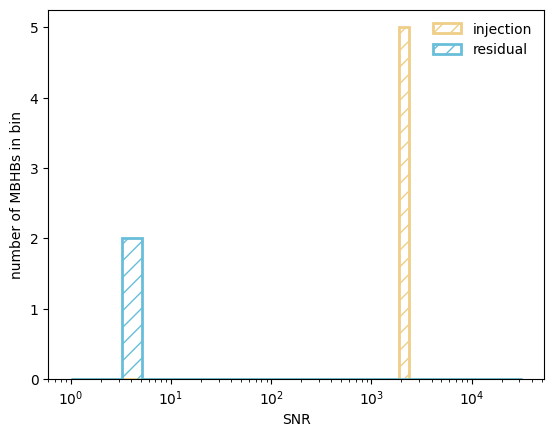

In [ ]:
bins = np.logspace(0, 4.5, 45)
plt.hist(snr_list, bins=bins, density=False, facecolor=None, edgecolor=YELLOW, hatch="//", histtype='step', lw=2, label="injection"); 
plt.hist(res_snr_list, bins=bins, density=False, facecolor=None, edgecolor=BLUE, hatch="//", histtype='step', lw=2, label="residual"); 
plt.xlabel("SNR")
plt.ylabel("number of MBHBs in bin")
plt.xscale("log")
plt.legend(loc="upper right", frameon=False)

In [ ]:
Mc_list = np.array([paramdict["chirp_mass"] for paramdict in truths_list])
q_list = np.array([paramdict["mass_ratio"] for paramdict in truths_list])
s1_list = np.array([paramdict["spin_1z"] for paramdict in truths_list])
s2_list = np.array([paramdict["spin_2z"] for paramdict in truths_list])
tc_list = np.array([paramdict["coalescence_time"] for paramdict in truths_list])
dl_list = np.array([paramdict["luminosity_distance"] for paramdict in truths_list])
inc_list = np.array([paramdict["inclination"] for paramdict in truths_list])
lon_list = np.array([paramdict["longitude"] for paramdict in truths_list])
lat_list = np.array([paramdict["latitude"] for paramdict in truths_list])

Mc_list1 = np.array([paramdict["chirp_mass"] for paramdict in searched_list])
q_list1 = np.array([paramdict["mass_ratio"] for paramdict in searched_list])
s1_list1 = np.array([paramdict["spin_1z"] for paramdict in searched_list])
s2_list1 = np.array([paramdict["spin_2z"] for paramdict in searched_list])
tc_list1 = np.array([paramdict["coalescence_time"] for paramdict in searched_list])
dl_list1 = np.array([paramdict["luminosity_distance"] for paramdict in searched_list])
inc_list1 = np.array([paramdict["inclination"] for paramdict in searched_list])
lon_list1 = np.array([paramdict["longitude"] for paramdict in searched_list])
lat_list1 = np.array([paramdict["latitude"] for paramdict in searched_list])

Mc_list2 = np.array([paramdict["chirp_mass"] for paramdict in FIM_bound_list])
q_list2 = np.array([paramdict["mass_ratio"] for paramdict in FIM_bound_list])
s1_list2 = np.array([paramdict["spin_1z"] for paramdict in FIM_bound_list])
s2_list2 = np.array([paramdict["spin_2z"] for paramdict in FIM_bound_list])
tc_list2 = np.array([paramdict["coalescence_time"] for paramdict in FIM_bound_list])
dl_list2 = np.array([paramdict["luminosity_distance"] for paramdict in FIM_bound_list])
inc_list2 = np.array([paramdict["inclination"] for paramdict in FIM_bound_list])
lon_list2 = np.array([paramdict["longitude"] for paramdict in FIM_bound_list])
lat_list2 = np.array([paramdict["latitude"] for paramdict in FIM_bound_list])

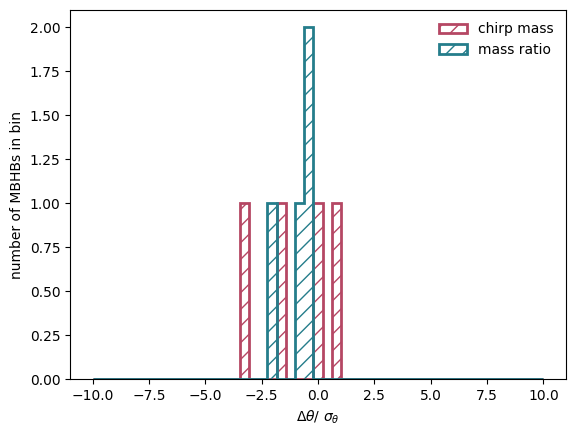

In [ ]:
bins = np.linspace(-10, 10, 50)
plt.hist((Mc_list1 - Mc_list) / Mc_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="chirp mass");
plt.hist((q_list1 - q_list) / q_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="mass ratio");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

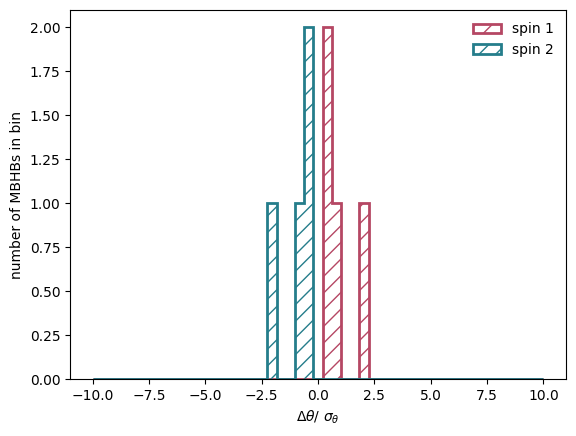

In [ ]:
bins = np.linspace(-10, 10, 50)
plt.hist((s1_list1 - s1_list) / s1_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="spin 1");
plt.hist((s2_list1 - s2_list) / s2_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="spin 2");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

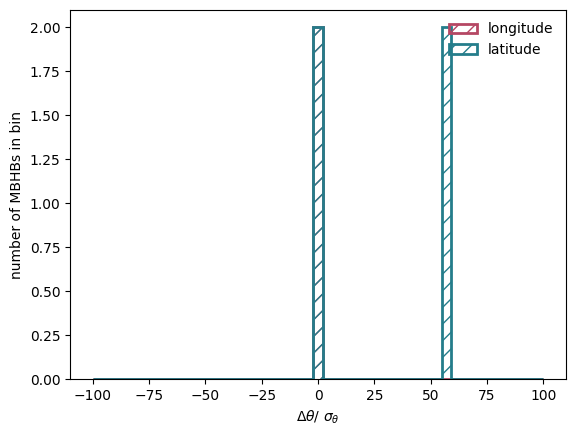

In [ ]:
bins = np.linspace(-100, 100, 50)
plt.hist((lon_list1 - lon_list) / lon_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="longitude");
plt.hist((lat_list1 - lat_list) / lat_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="latitude");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

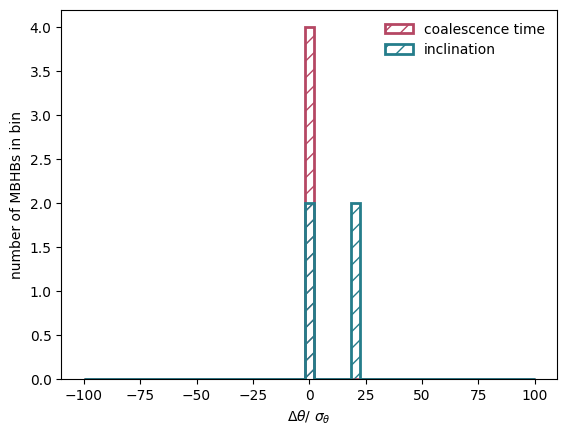

In [ ]:
bins = np.linspace(-100, 100, 50)
plt.hist((tc_list1 - tc_list) / tc_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="coalescence time");
plt.hist((inc_list1 - inc_list) / inc_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="inclination");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

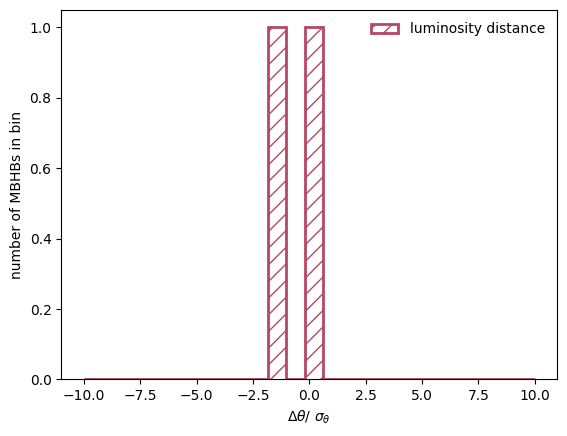

In [ ]:
bins = np.linspace(-10, 10, 50)
plt.hist((dl_list1 - dl_list) / dl_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="luminosity distance");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

In [ ]:
lon_list, lon_list1, lon_list2

(array([5.56733383, 5.56733383, 5.56733383, 5.56733383]),
 array([0.05377418, 0.06339419, 5.5820676 , 5.55195966]),
 array([0.01284622, 0.01284622, 0.01284622, 0.01284622]))

In [ ]:
lat_list, lat_list1, lat_list2

(array([0.50865564, 0.50865564, 0.50865564, 0.50865564]),
 array([1.00751747, 1.03102996, 0.50825782, 0.49817239]),
 array([0.00892593, 0.00892593, 0.00892593, 0.00892593]))

In [ ]:
inc_list, inc_list1, inc_list2

(array([0.74808404, 0.74808404, 0.74808404, 0.74808404]),
 array([2.42036082, 2.29071645, 0.72023419, 0.83803669]),
 array([0.07549262, 0.07549262, 0.07549262, 0.07549262]))